In [1]:
from sklearn.datasets import fetch_openml
from manualMLP import NeuralMLP
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

# normalize X to have features between -1 and 1 - this  stabilizes gradient based updates just like normalizing
# but -1 to 1 works better with pixels typically
# X ranges from 0 to 255 (8-bit encoding for B/W images)
X = ((X / 255.) - 0.5) *2

(70000, 784)
(70000,)


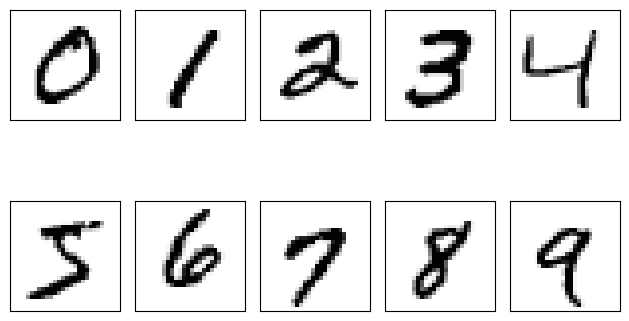

This is just one example - people write each number with different handwriting, and different styles


In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(10):
    img = X[y==i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

print("This is just one example - people write each number with different handwriting, and different styles")

In [4]:
# We have 70,000 images - split 10000 away for testing
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y
)
# Split 5000 away for validation, and keep the rest for training
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp
)

In [27]:
model = NeuralMLP(num_features=28*28, num_hidden=50, num_classes=10)

In [28]:
num_epochs = 50
minibatch_size = 100

def generate_minibatch(X, y, batch_size=minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
        batch_idx = indices[start_idx:start_idx + batch_size]
        yield X[batch_idx], y[batch_idx]

In [29]:
def compute_metrics(nnet, X, y, batch_size=minibatch_size):
    mse, correct_preds, num_examples = 0.0, 0, 0
    minibatch_gen = generate_minibatch(X, y, batch_size)
    for i, (features, targets)  in enumerate(minibatch_gen):
        _, probs = nnet.forward(features)
        mse += nnet.mse(targets, probs) * features.shape[0]
        preds = np.argmax(probs, axis=1)
        correct_preds += np.sum(preds == targets)
        num_examples += features.shape[0]
    mse /= num_examples
    acc = correct_preds / num_examples
    return mse, acc

In [30]:
mse, acc = compute_metrics(model, X_valid, y_valid)
print("Untrained model")
print(f"MSE: {mse}")
print(f"Accuracy: {acc*100:.2f}%.")

Untrained model
MSE: 0.27765605281717515
Accuracy: 9.64%.


In [31]:
def train(nnet, X_train, y_train, X_validate, y_validate, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_validation_acc = []

    for e in range(num_epochs):
        minibatch_gen = generate_minibatch(X_train, y_train, minibatch_size)
        for X_train_batch, y_train_batch in minibatch_gen:
            
            # Outputs
            a_h, a_out = nnet.forward(X_train_batch)
            
            # Loss gradients
            d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h = nnet.backward(X_train_batch, a_h, a_out, y_train_batch)

            # Update weights
            nnet.weight_h -= learning_rate * d_loss__d_w_h
            nnet.weight_out -= learning_rate * d_loss__dw_out

            nnet.bias_h -= learning_rate * d_loss__d_b_h
            nnet.bias_out -= learning_rate * d_loss__db_out

        train_mse, train_acc = compute_metrics(nnet, X_train, y_train)
        validation_mse, validation_acc = compute_metrics(nnet, X_validate, y_validate)

        epoch_train_acc.append(train_acc)
        epoch_validation_acc.append(validation_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} | Train MSE: {train_mse:.2f} | Train Acc: {train_acc*100:.2f}% | Valid Acc: {validation_acc*100:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_validation_acc

In [32]:
epoch_loss, epoch_training_acc, epoch_validation_acc = train(model, X_train, y_train, X_valid, y_valid, num_epochs=100, learning_rate=0.1)

Epoch: 001/100 | Train MSE: 0.05 | Train Acc: 71.72% | Valid Acc: 72.06%
Epoch: 002/100 | Train MSE: 0.03 | Train Acc: 85.80% | Valid Acc: 85.68%
Epoch: 003/100 | Train MSE: 0.02 | Train Acc: 88.41% | Valid Acc: 88.30%
Epoch: 004/100 | Train MSE: 0.02 | Train Acc: 89.40% | Valid Acc: 89.08%
Epoch: 005/100 | Train MSE: 0.02 | Train Acc: 90.15% | Valid Acc: 89.84%
Epoch: 006/100 | Train MSE: 0.02 | Train Acc: 90.60% | Valid Acc: 90.18%
Epoch: 007/100 | Train MSE: 0.02 | Train Acc: 90.97% | Valid Acc: 90.68%
Epoch: 008/100 | Train MSE: 0.02 | Train Acc: 91.34% | Valid Acc: 91.14%
Epoch: 009/100 | Train MSE: 0.01 | Train Acc: 91.62% | Valid Acc: 91.30%
Epoch: 010/100 | Train MSE: 0.01 | Train Acc: 91.85% | Valid Acc: 91.72%
Epoch: 011/100 | Train MSE: 0.01 | Train Acc: 92.05% | Valid Acc: 91.74%
Epoch: 012/100 | Train MSE: 0.01 | Train Acc: 92.28% | Valid Acc: 92.02%
Epoch: 013/100 | Train MSE: 0.01 | Train Acc: 92.54% | Valid Acc: 92.16%
Epoch: 014/100 | Train MSE: 0.01 | Train Acc: 92.66

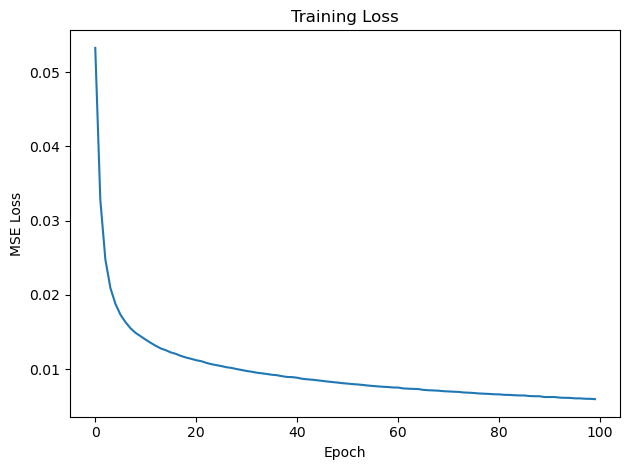

In [35]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.tight_layout()
plt.show()

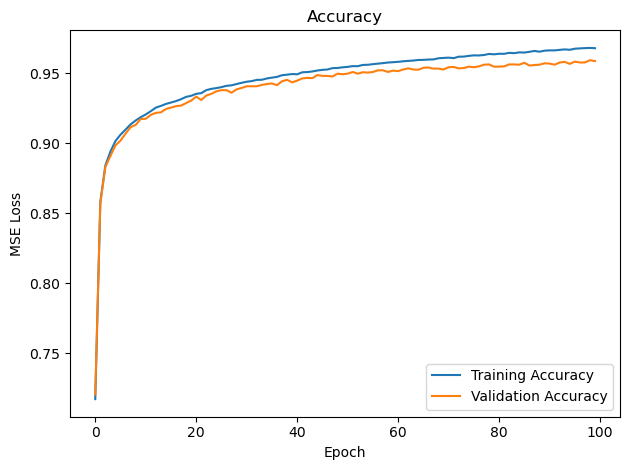

In [36]:
plt.plot(range(len(epoch_training_acc)), epoch_training_acc, label="Training Accuracy")
plt.plot(range(len(epoch_validation_acc)), epoch_validation_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Accuracy")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [38]:
test_mse, test_acc = compute_metrics(model, X_test, y_test)
print("Post-training testing:")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Post-training testing:
Test MSE: 0.01
Test Accuracy: 95.48%


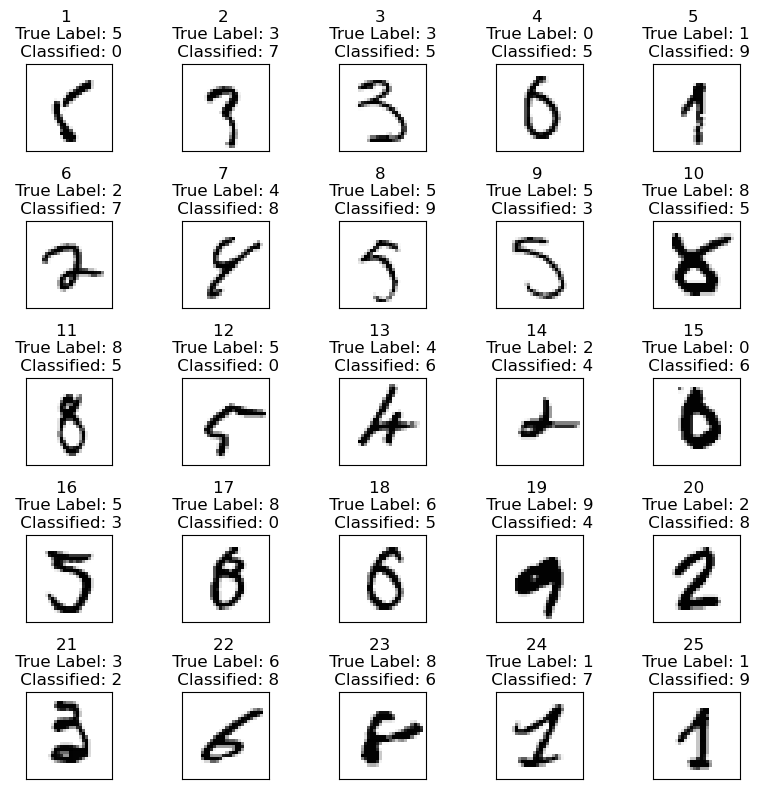

In [42]:
# Let's look at a subset of images that were misclassified
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probs = model.forward(X_test_subset)
test_subset_pred = np.argmax(probs, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_subset_pred][:25]
misclassified_labels = test_subset_pred[y_test_subset != test_subset_pred][:25]
true_labels = y_test_subset[y_test_subset != test_subset_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))

ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys", interpolation='nearest')
    ax[i].set_title(f"{i + 1} \n True Label: {true_labels[i]} \n Classified: {misclassified_labels[i]}")

ax[0].set_xticks([])
ax[0].set_yticks([])


# plt.title("Misclassified Examples")
plt.tight_layout()
plt.show()